In [1]:
#installing necessary libraries
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchmetrics
from torchmetrics.classification import Accuracy   
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report

In [4]:
#Loading the dataset
df= pd.read_csv(r'C:\Users\LENOVO\Downloads\IDS-2018_Intrusion.csv')
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [5]:
df.shape

(1048575, 80)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  float64
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [ ]:
#Checking for missing values if any
df.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [ ]:
#checking for duplicate values if any
df.duplicated().sum()

5459

In [19]:
#Checking for duplicate columns if any
dupes = df.columns[df.columns.duplicated()].tolist()
if dupes:
    print("Duplicate columns:", dupes)

In [9]:
#Removing whitespace from column names if any
df.columns = df.columns.str.strip()

In [10]:
#Checking class distribution
df['Label'].value_counts()

Label
Benign    762384
Bot       286191
Name: count, dtype: int64

In [11]:
#Handling missing/infinite values if any
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df = df.replace([np.inf, -np.inf], np.nan)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [12]:
#Removing constant columns if any
const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
if const_cols:
    df = df.drop(columns=const_cols)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

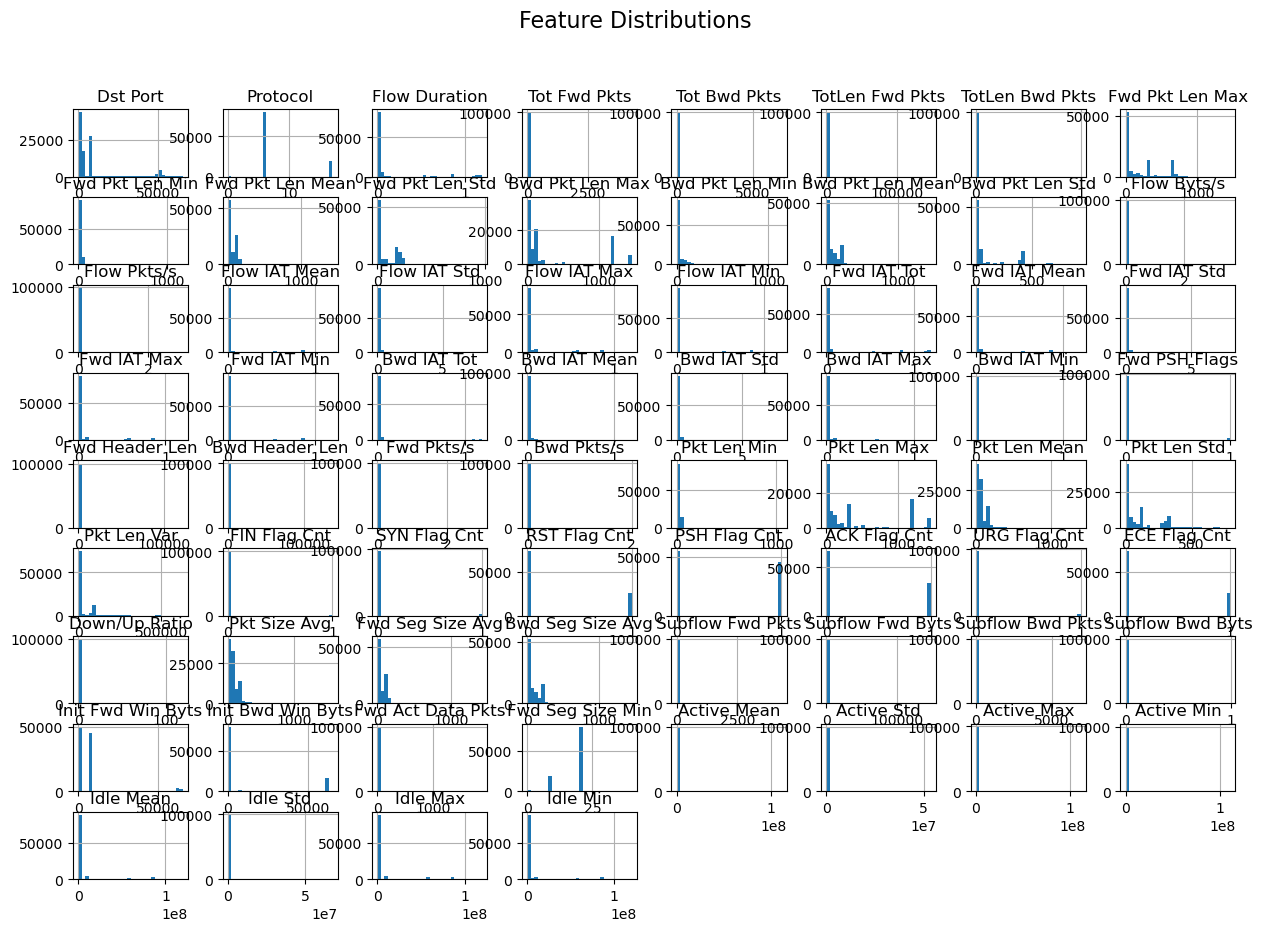

In [13]:
#EDAs
#Plotting distributions of numeric features
sample = df.sample(n=min(100000, len(df)), random_state=42)
sample[numeric_cols].hist(figsize=(15,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [14]:
#Encoding categorical variables
df['Label_num'] = df['Label'].map({'Benign': 0, 'Bot': 1})
if df['Label_num'].isnull().any():
    df['Label_num'] = pd.factorize(df['Label'])[0]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

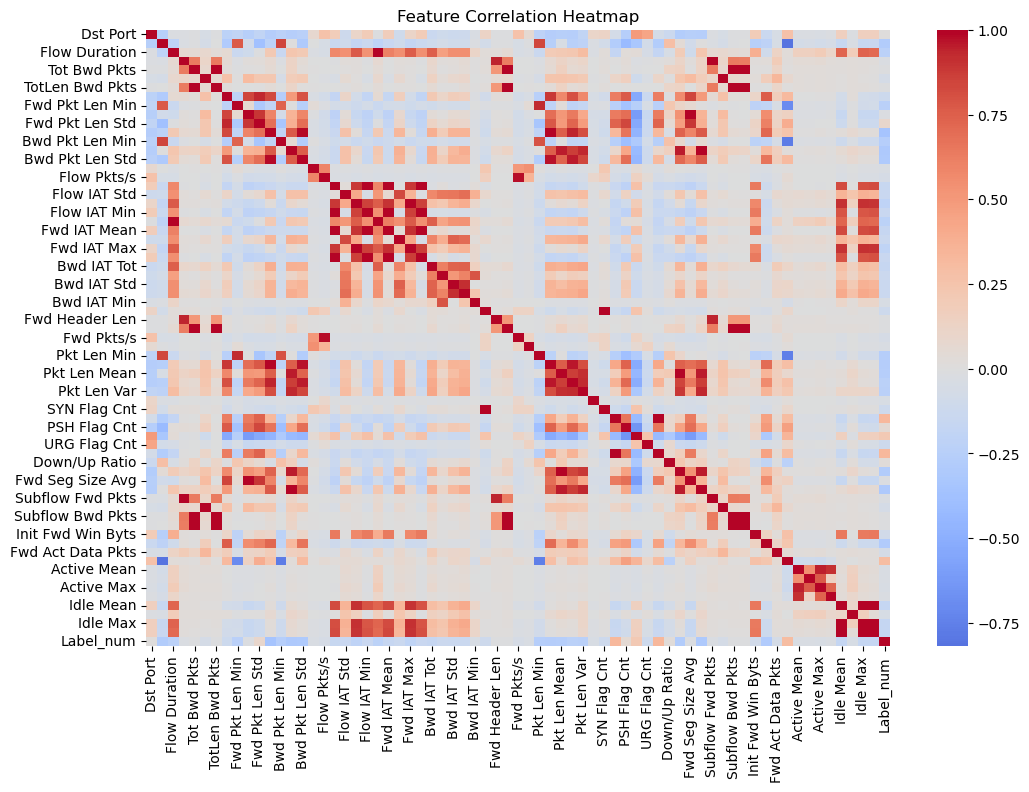

Label_num           1.000000
RST Flag Cnt        0.326886
ECE Flag Cnt        0.326884
Fwd Seg Size Min    0.299118
ACK Flag Cnt        0.214112
Fwd Pkt Len Std     0.085938
PSH Flag Cnt        0.052367
Down/Up Ratio       0.023741
Dst Port            0.012039
TotLen Bwd Pkts    -0.010323
dtype: float64


In [20]:
#Correlation Heatmap
corr = df[numeric_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Top 10 correlations with target
target_corr = df[numeric_cols].corrwith(df['Label_num']).sort_values(ascending=False)
print(target_corr.head(10))

Highly skewed features: Fwd Header Len       435.195412
Fwd Act Data Pkts    423.788228
Subflow Fwd Pkts     319.227492
Tot Fwd Pkts         319.227492
Subflow Fwd Byts     274.164884
                        ...    
Pkt Len Max            1.105984
RST Flag Cnt           1.068389
ECE Flag Cnt           1.068383
Label_num              1.019455
Fwd Seg Size Min      -1.507484
Length: 66, dtype: float64


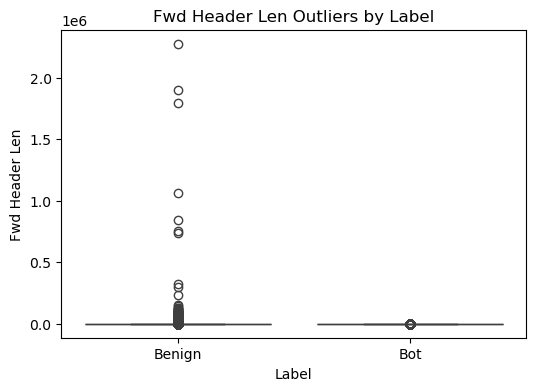

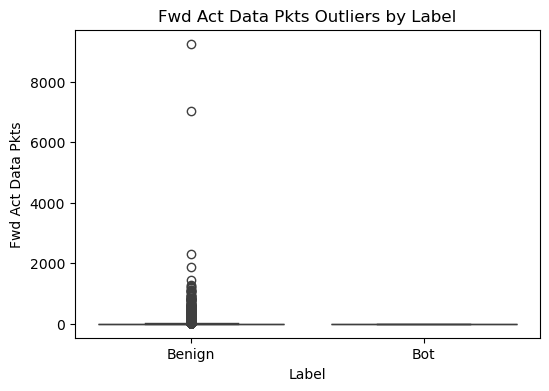

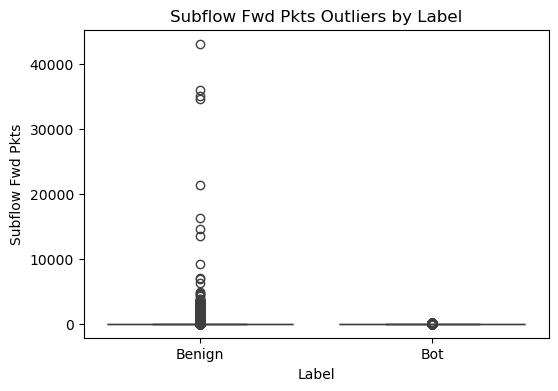

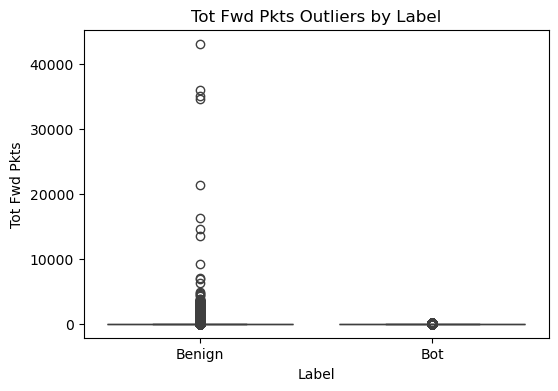

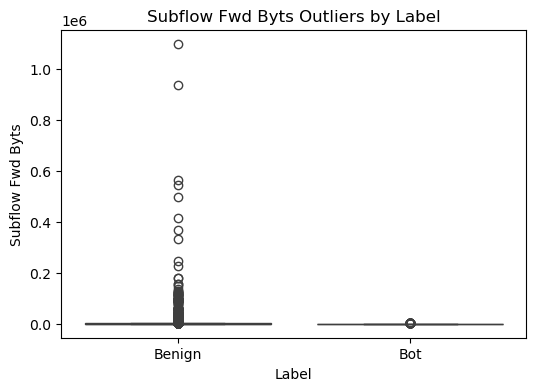

In [21]:
#Identifying highly skewed features
skewed_feats = df[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 1]
print("Highly skewed features:", high_skew)

# boxplots
for col in high_skew.index[:5]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='Label', y=col)
    plt.title(f"{col} Outliers by Label")
    plt.show()

C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


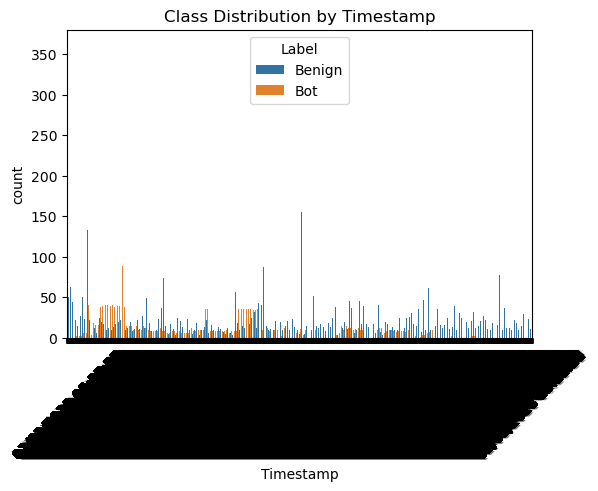

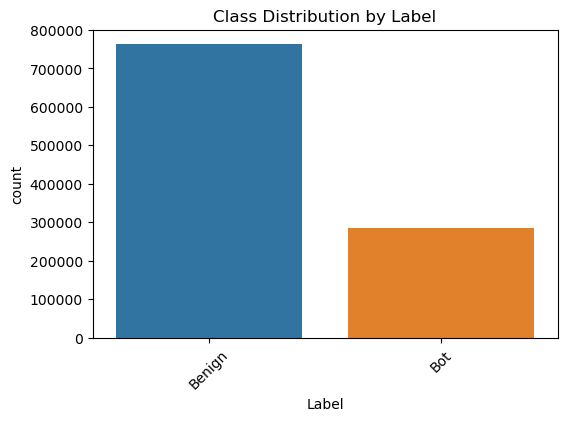

In [22]:
#Categorial feature distributions
for c in cat_cols[:3]:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=c, hue='Label')
    plt.title(f"Class Distribution by {c}")
    plt.xticks(rotation=45)
    plt.show()

In [23]:
#Encoding categorical features
cat_cols = [c for c in cat_cols if c!='Label']
df = pd.get_dummies(df, columns=[c for c in cat_cols if df[c].nunique()<=20], drop_first=True)
df = df.drop(columns=[c for c in ['Timestamp'] if c in df.columns], errors='ignore')

In [24]:
#Splitting the dataset into training and testing sets
X = df.drop(columns=['Label', 'Label_num'], errors='ignore')
y = df['Label_num']
assert all(dtype.kind in 'fiu' for dtype in X.dtypes), "Non-numeric columns remain in X"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
#Feature Scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)

In [ ]:

# if 'Timestamp' in X_train.columns:
#     print("Dropping 'Timestamp' column (non-numeric).")
#     X_train = X_train.drop(columns=['Timestamp'], errors='ignore')
#     X_test  = X_test.drop(columns=['Timestamp'],  errors='ignore')
#     numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

Numeric columns count: 68


In [27]:
#Model Building
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
#Creating a Neural Network model
layer0= nn.Linear(X_train.shape[1], 512)
layer1= nn.Linear(512, 256)
layer2= nn.Linear(256, 128)
layer3= nn.Linear(128, 2)
#Weight initialization
nn.init.uniform_(layer0.weight)
nn.init.uniform_(layer1.weight)
nn.init.uniform_(layer2.weight)
nn.init.uniform_(layer3.weight)
model= nn.Sequential(
    layer0,
    nn.ReLU(),
    nn.Dropout(0.25),
    layer1,
    nn.ReLU(),
    nn.Dropout(0.25),
    layer2,
    nn.ReLU(),
    layer3
)
model = model.to(device)

In [28]:
#Custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
model.apply(init_weights)

Sequential(
  (0): Linear(in_features=68, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=2, bias=True)
)

In [29]:
#Computing class weights to handle class imbalance
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)


In [30]:
#Choosing loss function
weight_tensor = torch.tensor(cw, dtype=torch.float, device=device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

In [31]:
#Defining dataset
X_train_tensor = torch.tensor(X_train.select_dtypes(include=['float64']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(float), dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset= TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2048, shuffle=False)

In [32]:
#Setting up optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [ ]:
#Running a training loop
max_epochs = 50
early_patience = 5
best_val_acc = -np.inf
patience_counter = 0
best_path = "best_model.pth"
metric = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long().view(-1)
        optimizer.zero_grad()
        outputs = torch.argmax(model(X_batch), dim=1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*X_batch.size(0)
    MTL= train_loss/len(train_loader)
    #Model validation
    model.eval()
    metric.reset()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long().view(-1)
            outputs = torch.argmax(model(X_batch), dim=1)
            preds = outputs.argmax(dim=1).cpu()
            metric.update(preds.cpu(), y_batch.cpu())
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()*X_batch.size(0)
    MVL= val_loss/len(val_loader.dataset)
    Accuracy= float(metric.compute())
    scheduler.step(Accuracy)
    if Accuracy > best_val_acc:
        best_val_acc = Accuracy
        torch.save(model.state_dict(), best_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_patience:
            print(f"Early stopping at epoch {epoch}. Best val Acc: {best_val_acc:.4f}")
            break 
    print(f"Epoch {epoch:02d} | Train loss: {train_loss:.4f})) | Val loss: {val_loss:.4f} | Val Acc: {Accuracy:.4f}")
    print(f"Mean Training Loss: {MTL:.4f} | Mean Validation Loss: {MVL:.4f}")
model.load_state_dict(torch.load(best_path, map_location=device))

RuntimeError: cross_entropy: weight tensor should be defined either for all 1024 classes or no classes but got weight tensor of shape: [2]

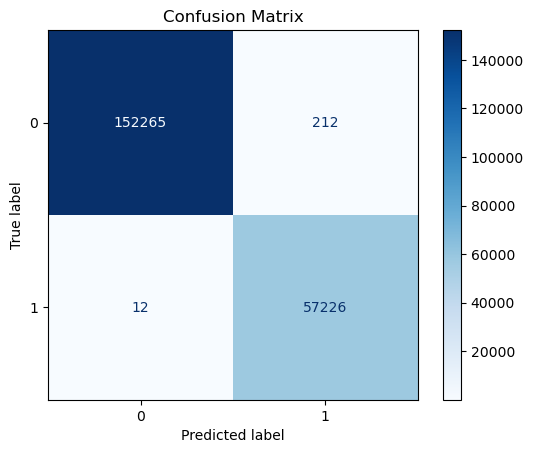

In [ ]:
#Model Evaluation
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)    
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
y_pred = torch.argmax(model(X_test_tensor), dim=1).detach()
cm = confusion_matrix(y_test_tensor, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152477
           1       1.00      1.00      1.00     57238

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



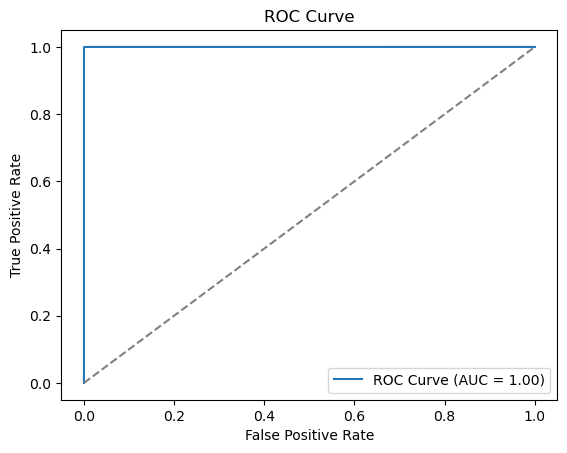

In [ ]:
#ROC Curve
y_probs = torch.softmax(model(X_test_tensor), dim=1)[:,1].detach().numpy()
fpr, tpr, _ = roc_curve(y_test_tensor, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

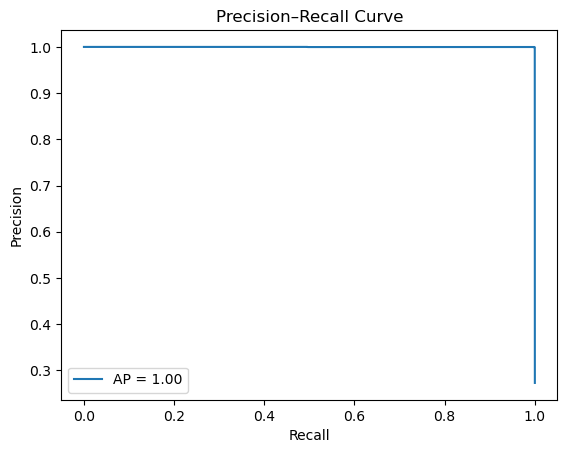

In [ ]:
#Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_tensor, y_probs)
ap = average_precision_score(y_test_tensor, y_probs)

plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()

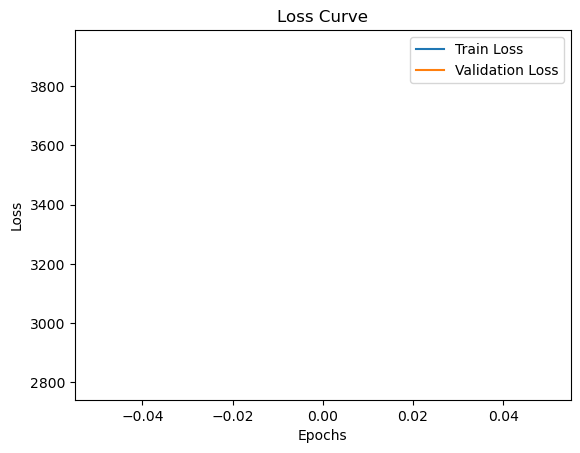

In [ ]:
#Loss Curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()